In [2]:
%matplotlib inline
import pickle
%run helper_functions.py
%run s3.py
%run show_cnf_mtx.py
pd.options.display.max_columns = 1000
plt.rcParams["figure.figsize"] = (15,10)
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.externals import joblib

import plotly.plotly as py
import plotly.graph_objs as go

In [3]:
working_bucket = 'gabr-project-3'

In [3]:
def best_features(feature_importance_list):
	all_features = []
	
	for index, importance_val in enumerate(feature_importance_list):
		all_features.append((index,importance_val))
	
	all_features = sorted(all_features, key=lambda x: x[1], reverse=True)
	
	best_features = all_features[:35]
	
	for i in best_features:
	    print(df.columns[i[0]])
	    try:
	        print(lookup_description(df.columns[i[0]]))
	    except:
	        print("DUMMY VARIABLE!")
	    print()

In [4]:
df = unpickle_object("rf_df_35.pkl")

In [5]:
y_vals = unpickle_object("dummied_dataset.pkl")

In [6]:
y = y_vals['loan_status_Late'].values
df.drop('loan_status_Late', inplace=True, axis=1)
X = df.values

             precision    recall  f1-score   support

       PAID       0.79      0.92      0.85    396204
CHARGED OFF       0.58      0.30      0.39    141804

avg / total       0.73      0.76      0.73    538008


Accuracy Score:  0.7586968967

F1 Score:  0.39427603615



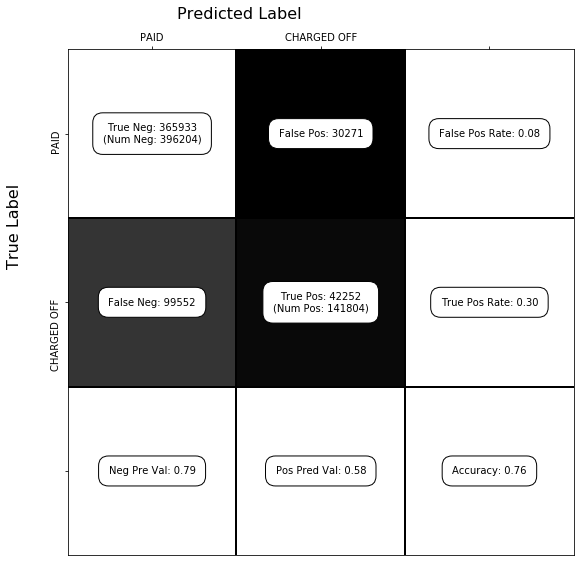


object fitted
int_rate
Interest Rate on the loan

dti
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

revol_util
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

revol_bal
Total credit revolving balance

installment
The monthly payment owed by the borrower if the loan originates.

avg_cur_bal
Average current balance of all accounts

bc_open_to_buy
Total open to buy on revolving bankcards.

tot_hi_cred_lim
Total high credit/credit limit

mo_sin_old_rev_tl_op
Months since oldest revolving account opened

total_bc_limit
Total bankcard high credit/credit limit

bc_util
Ratio of total current balance to high credit/credit limit for all bankcard accounts.

total_bal_ex_mort
Total credit balance excluding mortgage

tot_cur_bal
Total current balance of all accounts

m

In [7]:
target_names = ["PAID", "CHARGED OFF"]

final_cv = StratifiedKFold(n_splits=11, shuffle=True, random_state=222)

final_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy', min_samples_split=10, class_weight='balanced', random_state=223)

y_pred = cross_val_predict(final_model, X, y, cv=final_cv, n_jobs=-1)

print(classification_report(y, y_pred,target_names=target_names))

print()

cnf_matrix = confusion_matrix(y, y_pred)

print("Accuracy Score: ", np.median(accuracy_score(y, y_pred)))

print()
print("F1 Score: ", np.median(f1_score(y, y_pred)))
print()
show_confusion_matrix(cnf_matrix, class_labels=target_names)
print()
fit_object = final_model.fit(X,y)

print("object fitted")
best_features(fit_object.feature_importances_)
print()
joblib.dump(fit_object, 'rf_35_model_final.pkl');
proba = cross_val_predict(final_model, X, y, cv=final_cv, method='predict_proba')

In [8]:
fpr, tpr, thresholds = roc_curve(y, proba[:, 1])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y, proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2

trace1 = go.Scatter(x=fpr[1], y=tpr[1], 
                    mode='lines', 
                    line=dict(color='darkorange', width=lw),
                    name='ROC curve (area = %0.2f)' % roc_auc[1]
                   )

trace2 = go.Scatter(x=[0, 1], y=[0, 1], 
                    mode='lines', 
                    line=dict(color='navy', width=lw, dash='dash'),
                    showlegend=False)


layout = go.Layout(title='Receiver operating characteristic example',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=[trace1, trace2], layout=layout)

py.iplot(fig)

/usr/local/lib/python3.5/dist-packages/plotly/plotly/plotly.py:218: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



The draw time for this plot will be slow for all clients.


/usr/local/lib/python3.5/dist-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



In [9]:
pickle_object(proba, "probabilities_array_rf_35_model_final")

In [7]:
proba = unpickle_object("probabilities_array_rf_35_model_final.pkl")

In [12]:
probs_of_0 = proba[:,0]

In [14]:
f1 = -1
final = [(0,0)]
for prob in np.arange(0.1,1, 0.01):
	test = []
	for i in probs_of_0:
		if i > prob:
			test.append(0)
		else:
			test.append(1)
	val = f1_score(y, test)


	if val > f1:
		f1 = val
		final.pop(0)
		final.append((prob, f1))
final

[(0.67999999999999972, 0.51695198474976412)]

The above shows us that we can maxiize our f1-score if we adjust the threshold to be ~0.68. That is to say, if our model predicts a probability of 0.68 or higher, then you will be classified as paying off your loan on time. Unfortunately, this parameter tuning has yet to be built into sklearns random forest classifier, thus it must be done by hand.

In [10]:
upload_to_bucket("rf_35_model_final.pkl", "rf_35_final_model.pkl", working_bucket)

rf_35_model_final.pkl uploaded to gabr-project-3 bucket with a key of rf_35_final_model.pkl


In [11]:
upload_to_bucket("probabilities_array_rf_35_model_final.pkl", "probabilities_array_rf_35_model_final.pkl", working_bucket)

probabilities_array_rf_35_model_final.pkl uploaded to gabr-project-3 bucket with a key of probabilities_array_rf_35_model_final.pkl
